# Main Program file for Cancer Predictive Model (Jupyter Notebook Version)
## By: Group CL_04

### Importing Libraries

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import os, random, shutil
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

# Test comment line from VS Code 2 pls tell me it works

### Dividing Dataset (70% training, 30% testing)

In [4]:
def img_train_test_split(root_dir, classes_dir, test_ratio):
    '''
    This function splits a folder with subfolders into train and test datasets
    :param root_dir: a string corresponding to the file path of the folder of subfolders of images
    :param classes_dir: a list of strings of subfolder names
    :param test_ratio: a float of the ratio of test dataset to train dataset
    :return: None
    '''

    for cls in classes_dir:
        # create a new train and test directory for cls
        os.makedirs(root_dir + 'train/' + cls)
        os.makedirs(root_dir + 'test/' + cls)

        # get pathname of cls
        src = root_dir + cls

        # split the filenames into chosen training and testing ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                   [int(len(allFileNames) * (1 - test_ratio))])

        # copy images into new train folder for cls subfolder
        for name in train_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'train/' + cls)

        # copy images into new test folder for cls subfolder
        for name in test_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'test/' + cls)
    return None

In [3]:
classes_dir = ['MSIMUT_JPEG', 'MSS_JPEG']
test_ratio = 0.3

In [5]:
# root_dir: filepath of coad_msi_mss with '/' at the back
root_dir = '/Users/vionnietan/Desktop/trial_dataset/'
# root_dir = '/Users/elainealverina/Desktop/trial_dataset/'

In [6]:
img_train_test_split(root_dir, classes_dir, test_ratio)

### Data Augmentation and Normalization

In [7]:
# batch_size = 128
learn_rate = 1e-3

data_transformation_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transformation_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

root_dir_train = '/Users/vionnietan/Desktop/trial_dataset/train'
# root_dir_train = '/Users/elainealverina/Desktop/trial_dataset/train'

root_dir_test = '/Users/vionnietan/Desktop/trial_dataset/test'
# root_dir_test = '/Users/elainealverina/Desktop/trial_dataset/test'


train_image_dataset = datasets.ImageFolder(root = root_dir_train, transform=data_transformation_train)
test_image_dataset = datasets.ImageFolder(root = root_dir_test, transform=data_transformation_test)

### Prepare DataLoader

In [8]:
train_image_dataloader = DataLoader(train_image_dataset, batch_size=128, shuffle=True)
test_image_dataloader = DataLoader(test_image_dataset, batch_size=128, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data Visualization (Display some images)

In [9]:
def show_image(images, title=None):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        if i < 5:
            plt.subplot(1, 6, i+1, xticks=[], yticks=[])
            image = image.cpu() if device else image
            image = image.numpy().transpose((1, 2, 0))

            # Denormalize image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)
            plt.imshow(image)

    plt.show()

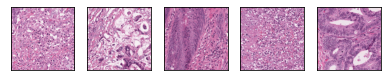

In [10]:
# Show Images of Training Data
images, labels = next(iter(train_image_dataloader))
#out = torchvision.utils.make_grid(images)
show_image(images)

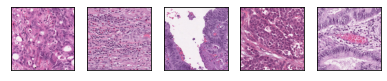

In [11]:
# Show Images of Testing Data
images_test, labels_test = next(iter(test_image_dataloader))
#out = torchvision.utils.make_grid(images)
show_image(images_test)

### Creating the Model - Load resnet18

In [13]:
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/vionnietan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Classifier architecture to put on top of resnet18
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

# Using Adam Optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001)

In [15]:
def show_preds():
    resnet18.eval()    # set to evaluation mode
    images, labels = next(iter(test_image_dataloader))
    out = resnet18(images)
    _ , preds = torch.max(out, dim=1)
    show_image(images)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


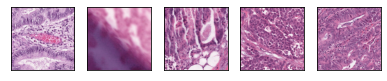

In [16]:
# Need to add labels to graph
show_preds()

### Freeze Parameters

In [ ]:
# Test commit 25 AUgust 2:36pm

### Training Model